# Entorno: Google Colab

In [64]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("flights_small.csv",sep=";")
df.head(3)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,5,20,3,WN,2433,N638SW,BNA,LGA,1150,...,1919.0,259.0,0,0,NaN,1.0,0.0,38.0,220.0,0.0
1,2015,11,23,1,AA,2256,N481AA,DFW,IAH,1550,...,1643.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,3,24,2,B6,585,N355JB,ROC,JFK,1840,...,1947.0,-20.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Transformaciones en PySpark

### Principales transformaciones en RDDs (PySpark)

Las transformaciones en RDDs devuelven un **nuevo RDD** y son perezosas (no se ejecutan hasta que se lanza una acción).

#### Transformaciones más comunes:

- `.map(func)`  
  Aplica una función a cada elemento del RDD.

- `.flatMap(func)`  
  Como `.map()`, pero puede devolver múltiples resultados por elemento (y los aplana).

- `.filter(func)`  
  Devuelve solo los elementos que cumplan una condición.

- `.distinct()`  
  Elimina duplicados.

- `.union(otherRDD)`  
  Une dos RDDs.

- `.intersection(otherRDD)`  
  Devuelve los elementos comunes entre dos RDDs.

- `.groupByKey()`  
  Agrupa valores por clave (solo para pares clave-valor).

- `.reduceByKey(func)`  
  Agrega valores por clave aplicando una función (más eficiente que `groupByKey`).

- `.sortBy(func)`  
  Ordena los elementos según una función.

In [65]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("flights").getOrCreate()

rdd = spark.createDataFrame(df[['AIRLINE', 'ARRIVAL_DELAY']].dropna()).rdd

rdd

MapPartitionsRDD[444] at javaToPython at <unknown>:0

In [66]:
rdd_tuplas = rdd.map(lambda row: (row['AIRLINE'], row['ARRIVAL_DELAY']))
rdd_tuplas.take(5)

[('WN', 259.0), ('AA', -15.0), ('B6', -20.0), ('OO', -18.0), ('DL', -33.0)]

In [67]:
rdd_filtrado = rdd_tuplas.filter(lambda x: x[1] > 60)
rdd_filtrado.take(5)

[('WN', 259.0), ('AA', 149.0), ('DL', 136.0), ('DL', 96.0), ('OO', 99.0)]

In [68]:
rdd_retrasos = rdd_filtrado.map(lambda x: (x[0], 1))
rdd_retrasos.take(5)

[('WN', 1), ('AA', 1), ('DL', 1), ('DL', 1), ('OO', 1)]

In [69]:
rdd_agrupado = rdd_retrasos.reduceByKey(lambda a, b: a + b)
rdd_agrupado.take(10)

[('DL', 69),
 ('UA', 58),
 ('F9', 11),
 ('B6', 31),
 ('NK', 17),
 ('WN', 111),
 ('AA', 67),
 ('OO', 51),
 ('EV', 72),
 ('VX', 7)]

In [70]:
rdd_texto = spark.sparkContext.parallelize(["A,B,C", "D,E"])
rdd_expandido = rdd_texto.flatMap(lambda x: x.split(","))
print(rdd_expandido.collect())

['A', 'B', 'C', 'D', 'E']


# Acciones en PySpark

### Principales acciones en RDDs (PySpark)

Las acciones en RDDs **disparan la ejecución real** del cálculo distribuido. Devuelven resultados o provocan efectos.

#### Acciones más comunes:

- `.collect()`  
  Devuelve todos los elementos del RDD como una lista en el driver (¡peligroso si hay muchos datos!).

- `.count()`  
  Cuenta cuántos elementos tiene el RDD.

- `.take(n)`  
  Devuelve una lista con los primeros `n` elementos.

- `.first()`  
  Devuelve el primer elemento del RDD.

- `.takeSample(withReplacement, num)`  
  Devuelve una muestra aleatoria del RDD.

- `.reduce(func)`  
  Aplica una función acumulativa a todos los elementos y devuelve un solo resultado.

- `.foreach(func)`  
  Aplica una función a cada elemento (no devuelve nada, útil para efectos secundarios).

- `.saveAsTextFile(path)`  
  Guarda el RDD como archivos de texto en el sistema de ficheros.

- `.saveAsSequenceFile(path)`  
  Guarda el RDD como archivo binario tipo Hadoop (clave-valor).

- `.max()` / `.min()` / `.sum()`  
  Devuelven el valor máximo, mínimo o la suma de los elementos.


In [71]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("flights").getOrCreate()

rdd = spark.createDataFrame(df[['AIRLINE', 'ARRIVAL_DELAY']].dropna()).rdd

rdd_tuplas = rdd.map(lambda row: (row['AIRLINE'], row['ARRIVAL_DELAY']))

print(rdd_tuplas.count())

9815


In [72]:
print(rdd_tuplas.take(5))

[('WN', 259.0), ('AA', -15.0), ('B6', -20.0), ('OO', -18.0), ('DL', -33.0)]


In [73]:
print(rdd_tuplas.filter(lambda x: x[1] > 60).count())

562


In [74]:
suma_total = rdd_tuplas.map(lambda x: x[1]).reduce(lambda a, b: a + b)
print(suma_total)

44007.0


In [75]:
rdd_tuplas.saveAsTextFile("salida_rdd_vuelos")

Py4JJavaError: An error occurred while calling o2427.saveAsTextFile.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory file:/content/salida_rdd_vuelos already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:131)
	at org.apache.spark.internal.io.HadoopMapRedWriteConfigUtil.assertConf(SparkHadoopWriter.scala:299)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:71)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1623)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1623)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1609)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1609)
	at org.apache.spark.api.java.JavaRDDLike.saveAsTextFile(JavaRDDLike.scala:564)
	at org.apache.spark.api.java.JavaRDDLike.saveAsTextFile$(JavaRDDLike.scala:563)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsTextFile(JavaRDDLike.scala:45)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


# DataFrames en PySpark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("flights").getOrCreate()

df_spark = spark.createDataFrame(df)

df_spark.printSchema()

In [ ]:
df_spark.show(5)

In [ ]:
df_spark.select("AIRLINE", "ORIGIN_AIRPORT", "DEPARTURE_DELAY").show(5)

In [ ]:
df_spark.filter(col("DEPARTURE_DELAY") > 60).show(5)

In [ ]:
df_spark.groupBy("AIRLINE").count().show()

In [ ]:
df_spark.select("AIRLINE","ARRIVAL_DELAY").na.drop().groupBy("AIRLINE").agg({"ARRIVAL_DELAY": "mean"}).show()

In [ ]:
df_spark.withColumn("RETRASO_TOTAL", col("DEPARTURE_DELAY") + col("ARRIVAL_DELAY")).select("AIRLINE", "RETRASO_TOTAL").show(5)

# Operaciones con DataFrames en PySpark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, count, round

spark = SparkSession.builder.appName("flights").getOrCreate()

df_spark = spark.createDataFrame(df)

df_spark.select("DEPARTURE_DELAY","ARRIVAL_DELAY").na.drop().select("DEPARTURE_DELAY", "ARRIVAL_DELAY").describe().show()

In [ ]:
df_spark.filter((col("DEPARTURE_DELAY") > 60) & (col("ARRIVAL_DELAY") > 60)).select("AIRLINE", "DEPARTURE_DELAY", "ARRIVAL_DELAY").show(5)

In [ ]:
df_spark.select("DEPARTURE_DELAY","ARRIVAL_DELAY","AIRLINE").na.drop().groupBy("AIRLINE").agg(
    mean("ARRIVAL_DELAY").alias("media_llegada"),
    mean("DEPARTURE_DELAY").alias("media_salida"),
    count("*").alias("num_vuelos")
).orderBy(col("media_llegada").desc()).show()

In [ ]:
df_spark.withColumn("RETRASO_TOTAL", col("DEPARTURE_DELAY") + col("ARRIVAL_DELAY")).select("AIRLINE", "RETRASO_TOTAL").show(5)

In [ ]:
df_spark.withColumn("RETRASO_TARDE", when(col("DEPARTURE_DELAY") > 15, 1).otherwise(0)).groupBy("AIRLINE").agg(
    mean("RETRASO_TARDE").alias("porcentaje_salidas_tarde")
).orderBy("porcentaje_salidas_tarde", ascending=False).show()

In [ ]:
df_spark.groupBy("MONTH").agg(
    count("*").alias("vuelos_totales"),
    round(mean("CANCELLED"), 4).alias("proporcion_cancelados")
).orderBy("MONTH").show()

In [ ]:
df_spark.select("ORIGIN_AIRPORT").distinct().count()

In [ ]:
df_spark.select("ARRIVAL_DELAY").na.drop().agg(
    {"ARRIVAL_DELAY": "max"}
).show()

# Acumuladores y operaciones numéricas

In [ ]:
from pyspark.sql import SparkSession
from pyspark import AccumulatorParam

spark = SparkSession.builder.appName("flights").getOrCreate()
sc = spark.sparkContext

rdd = spark.createDataFrame(df[['ARRIVAL_DELAY', 'DEPARTURE_DELAY']].dropna()).rdd

retrasos_llegada = sc.accumulator(0)
retrasos_salida = sc.accumulator(0)

def contar_retrasos(row):
    if row['ARRIVAL_DELAY'] > 15:
        retrasos_llegada.add(1)
    if row['DEPARTURE_DELAY'] > 15:
        retrasos_salida.add(1)

rdd.foreach(contar_retrasos)

print("Vuelos con retraso en llegada: " + str(retrasos_llegada.value))
print("Vuelos con retraso en salida: " + str(retrasos_salida.value))

suma_total = rdd.map(lambda row: row['ARRIVAL_DELAY']).sum()
media = rdd.map(lambda row: row['ARRIVAL_DELAY']).mean()
maximo = rdd.map(lambda row: row['ARRIVAL_DELAY']).max()
minimo = rdd.map(lambda row: row['ARRIVAL_DELAY']).min()

print("Suma total: " + str(suma_total))
print("Media: " + str(media))
print("Máximo: " + str(maximo))
print("Mínimo: " + str(minimo))

# MapReduce: Introducción

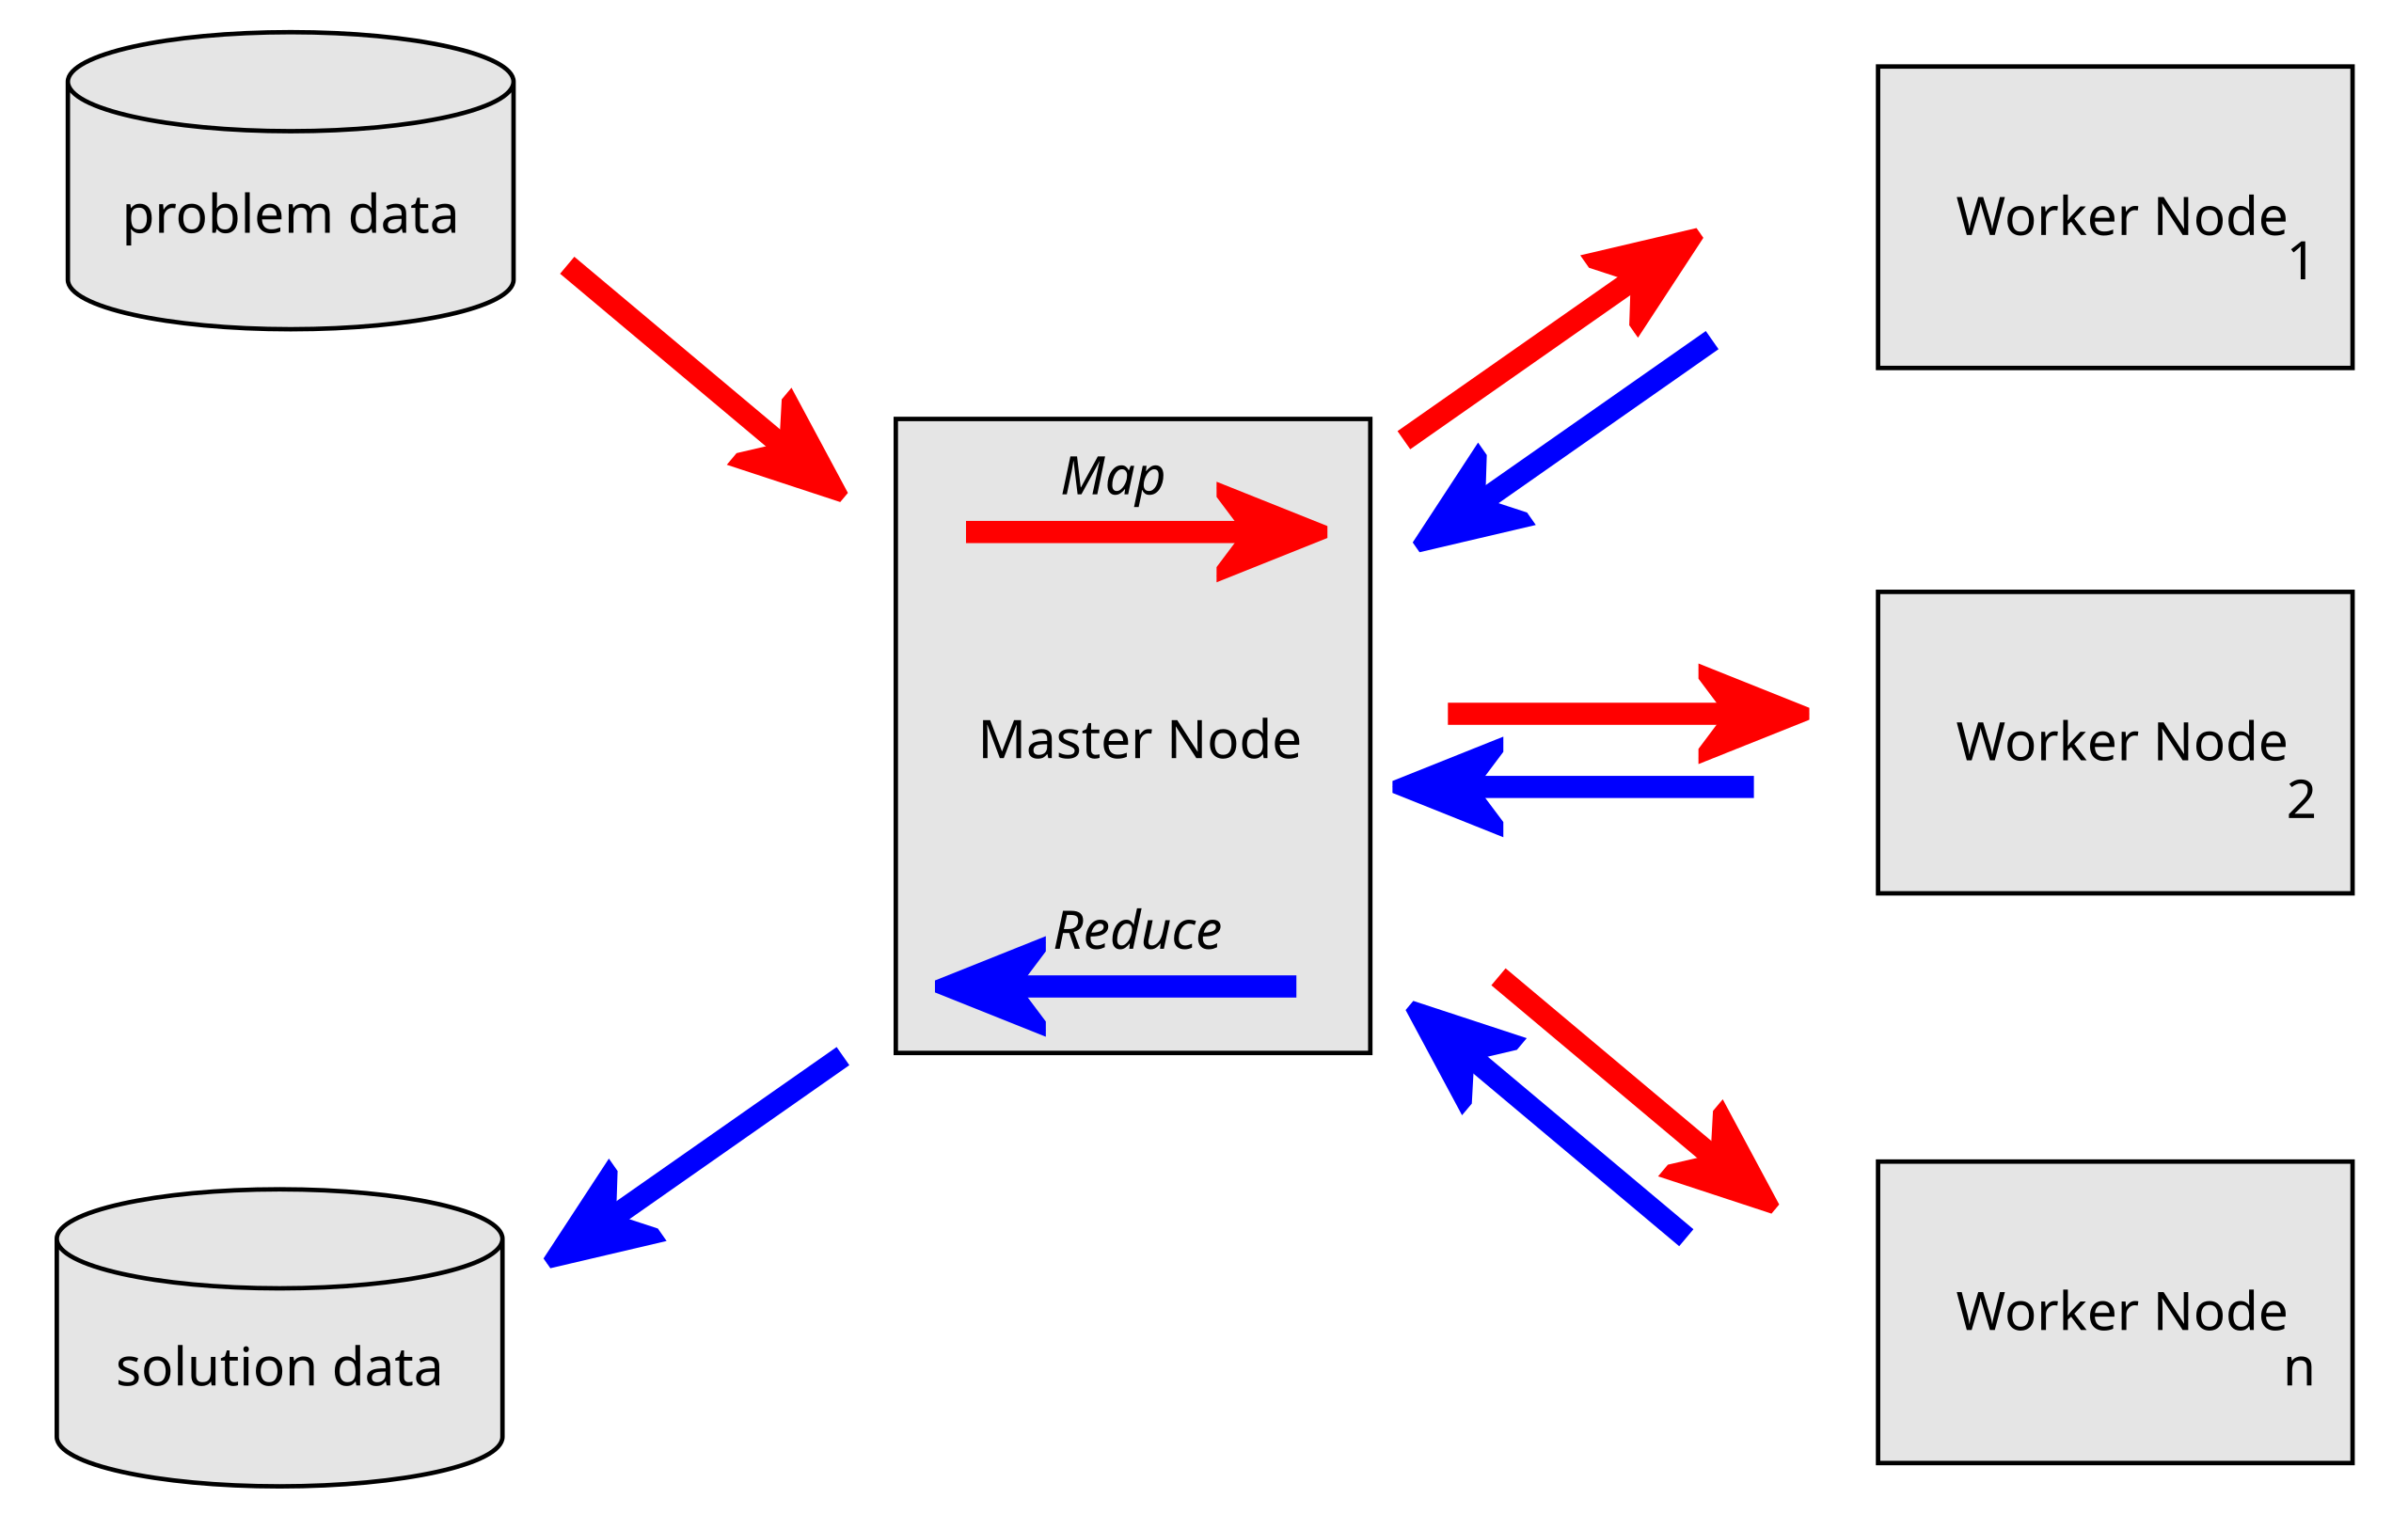

In [ ]:
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("mapreduce").getOrCreate()
rdd = spark.createDataFrame(df[['ORIGIN_AIRPORT', 'ARRIVAL_DELAY']].dropna()).rdd

rdd_map = rdd.map(lambda row: (row['ORIGIN_AIRPORT'], (row['ARRIVAL_DELAY'], 1)))

# ('JFK', (5.0, 1))
# ('JFK', (8.0, 1))
# ('JFK', (3.0, 1))

#reduce
rdd_reduce = rdd_map.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

rdd_resultado = rdd_reduce.mapValues(lambda x: x[0] / x[1])

rdd_resultado.collect()

# Construir nuestras propias funciones Map Reduce

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("mapreduce_avanzado").getOrCreate()

rdd = spark.createDataFrame(df[['AIRLINE', 'ORIGIN_AIRPORT', 'ARRIVAL_DELAY']].dropna()).rdd

def construir_clave(row):
    return ((row['AIRLINE'], row['ORIGIN_AIRPORT']), (row['ARRIVAL_DELAY'], 1))

def acumular(val1, val2):
    return (val1[0] + val2[0], val1[1] + val2[1])

def calcular_media_saturada(tupla):
    total, cuenta = tupla
    media = total / cuenta
    if media > 300:
        media = 300
    elif media < -60:
        media = -60
    return media

rdd_clave = rdd.map(construir_clave)

rdd_agregado = rdd_clave.reduceByKey(acumular)

rdd_media = rdd_agregado.mapValues(calcular_media_saturada)

rdd_ordenado = rdd_media.sortBy(lambda x: x[1], ascending=False)

top_resultados = rdd_ordenado.take(15)

for fila in top_resultados:
    print(fila)
